In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import kagglehub

### GPU 설정

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 하이퍼파라미터 설정

In [15]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
IMG_SIZE = 288  # EfficientNet-B2 권장 입력 크기
NUM_CLASSES = 101

In [16]:
class Food101Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # 모든 이미지 경로와 라벨 수집
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[class_name]))
        
        print(f"Found {len(self.samples)} images in {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # 에러 발생시 첫 번째 이미지 반환
            return self.__getitem__(0)

### 데이터 증강 및 전처리

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
class EfficientNetB2Classifier(nn.Module):
    def __init__(self, num_classes=101, pretrained=True):
        super(EfficientNetB2Classifier, self).__init__()
        
        # EfficientNet-B2 백본 로드
        self.backbone = models.efficientnet_b2(pretrained=pretrained)
        
        # 분류기 교체
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [19]:
def create_data_loaders(data_dir):
    """데이터 로더 생성 및 train/val/test 분할"""
    
    # 전체 데이터셋 로드
    full_dataset = Food101Dataset(data_dir, transform=train_transforms)
    
    # 클래스 정보 저장
    class_names = full_dataset.classes
    with open('class_names.json', 'w') as f:
        json.dump(class_names, f)
    
    # 데이터 분할 (70% train, 15% val, 15% test)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # Validation과 Test 데이터셋에 다른 transform 적용
    val_dataset.dataset.transform = val_transforms
    test_dataset.dataset.transform = val_transforms
    
    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, class_names

In [20]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    """모델 훈련"""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    # Early Stopping 설정
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                output = model(data)
                loss = criterion(output, target)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                
                with torch.cuda.amp.autocast():
                    output = model(data)
                    loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Val Accuracy: {val_acc:.2f}%')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
        
        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # 성능 향상 시 카운터 리셋
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': avg_val_loss
            }, 'best_food101_efficientnet_b2.pth')
            print(f'  New best model saved! (Val Acc: {val_acc:.2f}%)')
        else:
            patience_counter += 1
            print(f'  No improvement ({patience_counter}/{patience})')
        
        # Early Stopping 체크
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_accuracies

In [21]:
def evaluate_model(model, test_loader, class_names):
    """모델 평가"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Testing')
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            
            with torch.cuda.amp.autocast():
                output = model(data)
            
            _, predicted = output.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # 정확도 계산
    test_acc = accuracy_score(all_targets, all_preds)
    print(f'\nTest Accuracy: {test_acc*100:.2f}%')
    
    # 분류 리포트
    report = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)
    print('\nClassification Report:')
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    return test_acc, report

In [22]:
def plot_training_history(train_losses, val_losses, val_accuracies):
    """훈련 과정 시각화"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(val_accuracies, label='Val Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def main():
    """메인 실행 함수"""
    
    # Kaggle 데이터셋 다운로드
    print("Downloading Food-101 dataset from Kaggle...")
    path = kagglehub.dataset_download("kmader/food41")
    print("Path to dataset files:", path)
    
    # images 폴더 경로 설정
    data_dir = os.path.join(path, "images")
    
    # 데이터 디렉토리 확인
    if not os.path.exists(data_dir):
        print(f"Images directory not found at {data_dir}")
        print("Available directories:")
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print(f"  - {item}")
        return
    
    print(f"Using data directory: {data_dir}")
    print("Creating data loaders...")
    train_loader, val_loader, test_loader, class_names = create_data_loaders(data_dir)
    
    print("Initializing model...")
    model = EfficientNetB2Classifier(num_classes=NUM_CLASSES, pretrained=True)
    model = model.to(device)
    
    # 모델 파라미터 수 출력
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    print("Starting training...")
    train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader)
    
    print("Loading best model for testing...")
    checkpoint = torch.load('best_food101_efficientnet_b2.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print("Evaluating on test set...")
    test_acc, report = evaluate_model(model, test_loader, class_names)
    
    print("Plotting training history...")
    plot_training_history(train_losses, val_losses, val_accuracies)
    
    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {max(val_accuracies):.2f}%")
    print(f"Test accuracy: {test_acc*100:.2f}%")

Path to dataset files: /home/beethoven/.cache/kagglehub/datasets/kmader/food41/versions/5
Using data directory: /home/beethoven/.cache/kagglehub/datasets/kmader/food41/versions/5/images
Creating data loaders...
Found 101000 images in 101 classes
Train: 70700, Val: 15150, Test: 15150
Initializing model...


/tmp/ipykernel_19013/1090254390.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Total parameters: 8,474,215
Trainable parameters: 8,474,215
Starting training...


Epoch 1/50 [Train]:   0%|          | 0/2210 [00:00<?, ?it/s]/tmp/ipykernel_19013/1090254390.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Val]:   0%|          | 0/474 [00:00<?, ?it/s]/tmp/ipykernel_19013/1090254390.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Val]: 100%|██████████| 474/474 [00:41<00:00, 11.34it/s, Loss=0.8980, Acc=66.12%]


Epoch 1/50:
  Train Loss: 1.9188
  Val Loss: 1.2823
  Val Accuracy: 66.12%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 66.12%)


Epoch 2/50 [Val]: 100%|██████████| 474/474 [00:39<00:00, 11.93it/s, Loss=0.7530, Acc=70.33%]


Epoch 2/50:
  Train Loss: 1.2422
  Val Loss: 1.1444
  Val Accuracy: 70.33%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 70.33%)


Epoch 3/50 [Val]: 100%|██████████| 474/474 [00:39<00:00, 11.87it/s, Loss=0.6216, Acc=72.88%]


Epoch 3/50:
  Train Loss: 1.0414
  Val Loss: 1.0715
  Val Accuracy: 72.88%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 72.88%)


Epoch 4/50 [Val]: 100%|██████████| 474/474 [00:39<00:00, 11.87it/s, Loss=0.8938, Acc=73.94%]


Epoch 4/50:
  Train Loss: 0.9118
  Val Loss: 1.0254
  Val Accuracy: 73.94%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 73.94%)


Epoch 5/50 [Val]: 100%|██████████| 474/474 [00:40<00:00, 11.84it/s, Loss=0.7387, Acc=74.26%]


Epoch 5/50:
  Train Loss: 0.8253
  Val Loss: 1.0465
  Val Accuracy: 74.26%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 74.26%)


Epoch 6/50 [Val]: 100%|██████████| 474/474 [00:47<00:00,  9.96it/s, Loss=0.3271, Acc=74.65%]


Epoch 6/50:
  Train Loss: 0.7396
  Val Loss: 1.0451
  Val Accuracy: 74.65%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 74.65%)


Epoch 7/50 [Val]: 100%|██████████| 474/474 [00:45<00:00, 10.35it/s, Loss=0.2576, Acc=75.23%]


Epoch 7/50:
  Train Loss: 0.6831
  Val Loss: 1.0164
  Val Accuracy: 75.23%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 75.23%)


Epoch 8/50 [Val]: 100%|██████████| 474/474 [00:41<00:00, 11.45it/s, Loss=0.2713, Acc=75.08%]


Epoch 8/50:
  Train Loss: 0.6264
  Val Loss: 1.0051
  Val Accuracy: 75.08%
  Learning Rate: 0.001000
--------------------------------------------------
  No improvement (1/5)


Epoch 9/50 [Val]: 100%|██████████| 474/474 [00:46<00:00, 10.30it/s, Loss=0.4530, Acc=75.77%]


Epoch 9/50:
  Train Loss: 0.5832
  Val Loss: 1.0301
  Val Accuracy: 75.77%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 75.77%)


Epoch 10/50 [Val]: 100%|██████████| 474/474 [00:48<00:00,  9.86it/s, Loss=0.0984, Acc=75.29%]


Epoch 10/50:
  Train Loss: 0.5417
  Val Loss: 1.0387
  Val Accuracy: 75.29%
  Learning Rate: 0.001000
--------------------------------------------------
  No improvement (1/5)


Epoch 11/50 [Val]: 100%|██████████| 474/474 [00:43<00:00, 10.86it/s, Loss=0.5186, Acc=74.84%]


Epoch 11/50:
  Train Loss: 0.5157
  Val Loss: 1.0512
  Val Accuracy: 74.84%
  Learning Rate: 0.001000
--------------------------------------------------
  No improvement (2/5)


Epoch 12/50 [Val]: 100%|██████████| 474/474 [00:40<00:00, 11.84it/s, Loss=0.7070, Acc=75.67%]


Epoch 12/50:
  Train Loss: 0.4827
  Val Loss: 1.0833
  Val Accuracy: 75.67%
  Learning Rate: 0.001000
--------------------------------------------------
  No improvement (3/5)


Epoch 13/50 [Val]: 100%|██████████| 474/474 [00:41<00:00, 11.37it/s, Loss=0.4916, Acc=76.10%]


Epoch 13/50:
  Train Loss: 0.4555
  Val Loss: 1.1117
  Val Accuracy: 76.10%
  Learning Rate: 0.001000
--------------------------------------------------
  New best model saved! (Val Acc: 76.10%)


Epoch 14/50 [Val]: 100%|██████████| 474/474 [00:43<00:00, 10.96it/s, Loss=1.0728, Acc=73.94%]


Epoch 14/50:
  Train Loss: 0.4404
  Val Loss: 1.1800
  Val Accuracy: 73.94%
  Learning Rate: 0.000500
--------------------------------------------------
  No improvement (1/5)


Epoch 15/50 [Val]: 100%|██████████| 474/474 [00:41<00:00, 11.37it/s, Loss=0.9689, Acc=78.42%]


Epoch 15/50:
  Train Loss: 0.2183
  Val Loss: 1.0440
  Val Accuracy: 78.42%
  Learning Rate: 0.000500
--------------------------------------------------
  New best model saved! (Val Acc: 78.42%)


Epoch 16/50 [Val]: 100%|██████████| 474/474 [00:40<00:00, 11.62it/s, Loss=1.4733, Acc=78.20%]


Epoch 16/50:
  Train Loss: 0.1574
  Val Loss: 1.1703
  Val Accuracy: 78.20%
  Learning Rate: 0.000500
--------------------------------------------------
  No improvement (1/5)


Epoch 17/50 [Val]: 100%|██████████| 474/474 [00:50<00:00,  9.41it/s, Loss=1.5695, Acc=77.84%]


Epoch 17/50:
  Train Loss: 0.1522
  Val Loss: 1.2054
  Val Accuracy: 77.84%
  Learning Rate: 0.000500
--------------------------------------------------
  No improvement (2/5)


Epoch 18/50 [Val]: 100%|██████████| 474/474 [00:50<00:00,  9.34it/s, Loss=0.7248, Acc=78.08%]


Epoch 18/50:
  Train Loss: 0.1367
  Val Loss: 1.1690
  Val Accuracy: 78.08%
  Learning Rate: 0.000500
--------------------------------------------------
  No improvement (3/5)


Epoch 19/50 [Val]: 100%|██████████| 474/474 [00:53<00:00,  8.80it/s, Loss=0.2986, Acc=77.75%]


Epoch 19/50:
  Train Loss: 0.1289
  Val Loss: 1.2243
  Val Accuracy: 77.75%
  Learning Rate: 0.000500
--------------------------------------------------
  No improvement (4/5)


Epoch 20/50 [Val]: 100%|██████████| 474/474 [00:54<00:00,  8.66it/s, Loss=0.4272, Acc=77.79%]


Epoch 20/50:
  Train Loss: 0.1295
  Val Loss: 1.2282
  Val Accuracy: 77.79%
  Learning Rate: 0.000250
--------------------------------------------------
  No improvement (5/5)
Early stopping triggered after 20 epochs
Loading best model for testing...
Evaluating on test set...


Testing:   0%|          | 0/474 [00:00<?, ?it/s]/tmp/ipykernel_19013/2412653460.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 474/474 [00:49<00:00,  9.59it/s]



Test Accuracy: 78.60%

Classification Report:
                         precision    recall  f1-score   support

              apple_pie       0.65      0.61      0.63       152
         baby_back_ribs       0.79      0.76      0.77       147
                baklava       0.92      0.78      0.85       162
         beef_carpaccio       0.82      0.85      0.84       154
           beef_tartare       0.78      0.82      0.80       138
             beet_salad       0.76      0.72      0.74       172
               beignets       0.89      0.87      0.88       164
               bibimbap       0.90      0.91      0.91       152
          bread_pudding       0.59      0.58      0.59       124
      breakfast_burrito       0.72      0.71      0.71       132
             bruschetta       0.65      0.73      0.68       140
           caesar_salad       0.89      0.81      0.84       154
                cannoli       0.81      0.86      0.83       149
          caprese_salad       0.82      0.

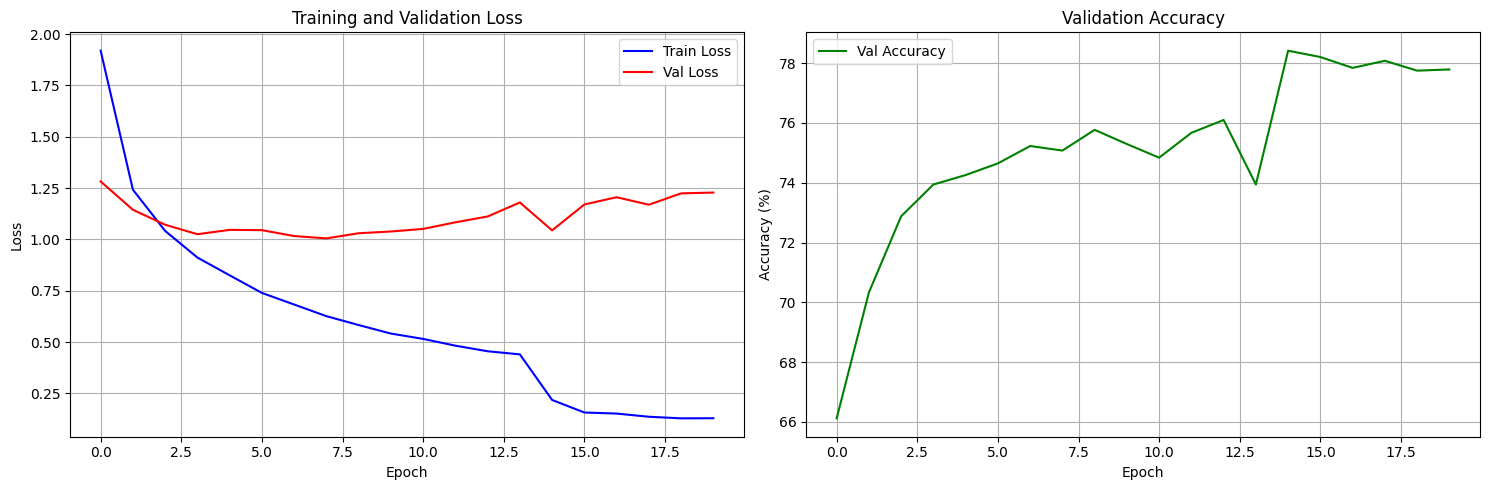


Training completed!
Best validation accuracy: 78.42%
Test accuracy: 78.60%


In [24]:
if __name__ == "__main__":
    main()